In [1]:
import os
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

import sys
sys.path.append('..')
import libfmp.b
import libfmp.c4
import libfmp.c5
import libfmp.c7


In [2]:
# Compute chromagram
fn_wav = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/if_0172.wav')
N = 4096
H = 2048
#X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
#X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

In [3]:
## Templates (modified)

## Original
# def generate_chord_templates(nonchord=False):
#     """Generate chord templates of major and minor triads (and possibly nonchord)

#     Notebook: C5/C5S2_ChordRec_Templates.ipynb

#     Args:
#         nonchord (bool): If "True" then add nonchord template (Default value = False)

#     Returns:
#         chord_templates (np.ndarray): Matrix containing chord_templates as columns
#     """
#     template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
#     template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
#     num_chord = 24
#     if nonchord:
#         num_chord = 25
#     chord_templates = np.ones((12, num_chord))
#     for shift in range(12):
#         chord_templates[:, shift] = np.roll(template_cmaj, shift)
#         chord_templates[:, shift+12] = np.roll(template_cmin, shift)
#     return chord_templates

## Modified

def generate_chord_templates(nonchord=False):
    """Generate chord templates for:
    - 12 major triads
    - 12 minor triads
    - 12 dominant seventh chords
    - 12 major seventh chords
    - 12 minor seventh chords
    - (Optional) one nonchord template (if nonchord=True)

    Returns:
        chord_templates (np.ndarray):
            Matrix of shape (12, num_chords), where each column is a binary chord template
    """
    # --- 1) Define base (C-root) triad templates ---
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])  # (C, E, G)
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])  # (C, Eb, G)

    # --- 2) Define base (C-root) seventh-chord templates ---
    # intervals for C7 = {0,4,7,10} (C, E, G, Bb)
    template_c7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

    # intervals for Cmaj7 = {0,4,7,11} (C, E, G, B)
    template_cmaj7 = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

    # intervals for Cm7 = {0,3,7,10} (C, Eb, G, Bb)
    template_cm7 = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])

    # --- 3) Prepare storage for all roots (12 columns per chord type) ---
    chord_templates_maj   = np.zeros((12, 12))
    chord_templates_min   = np.zeros((12, 12))
    chord_templates_dom7  = np.zeros((12, 12))
    chord_templates_maj7  = np.zeros((12, 12))
    chord_templates_min7  = np.zeros((12, 12))

    # --- 4) Fill each chord-type matrix by cyclically shifting the base templates ---
    for shift in range(12):
        chord_templates_maj[:, shift]   = np.roll(template_cmaj, shift)
        chord_templates_min[:, shift]   = np.roll(template_cmin, shift)
        chord_templates_dom7[:, shift]  = np.roll(template_c7,   shift)
        chord_templates_maj7[:, shift]  = np.roll(template_cmaj7, shift)
        chord_templates_min7[:, shift]  = np.roll(template_cm7,   shift)

    # --- 5) Stack the chord types horizontally ---
    #    major triads (12) + minor triads (12) +
    #    dominant 7 (12) + major 7 (12) + minor 7 (12) = 60 columns
    chord_templates = np.hstack([
        chord_templates_maj,
        chord_templates_min,
        chord_templates_dom7,
        chord_templates_maj7,
        chord_templates_min7
    ])

    # --- 6) Optionally add a "nonchord" column if requested ---
    if nonchord:
        # e.g. a zero vector or all-ones vector, depending on your preference.
        # Here we add a zero vector:
        nonchord_col = np.zeros((12, 1))  
        chord_templates = np.hstack([chord_templates, nonchord_col])

    return chord_templates

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max


def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def get_chord_labels_extended(nonchord=False):
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 
                     'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Triads
    chord_labels_maj = chroma_labels
    chord_labels_min = [note + 'm' for note in chroma_labels]

    # Seventh chords
    chord_labels_dom7 = [note + '7'    for note in chroma_labels]
    chord_labels_maj7 = [note + 'maj7' for note in chroma_labels]
    chord_labels_min7 = [note + 'm7'   for note in chroma_labels]

    chord_labels = (chord_labels_maj 
                    + chord_labels_min
                    + chord_labels_dom7
                    + chord_labels_maj7
                    + chord_labels_min7)

    if nonchord:
        chord_labels += ['N']

    return chord_labels

In [4]:
# # Original
# # Chord recognition
# chord_sim, chord_max = libfmp.c5.chord_recognition_template(X, norm_sim='max')
# chord_labels = libfmp.c5.get_chord_labels()

In [5]:
# Chord recognition
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels_extended()


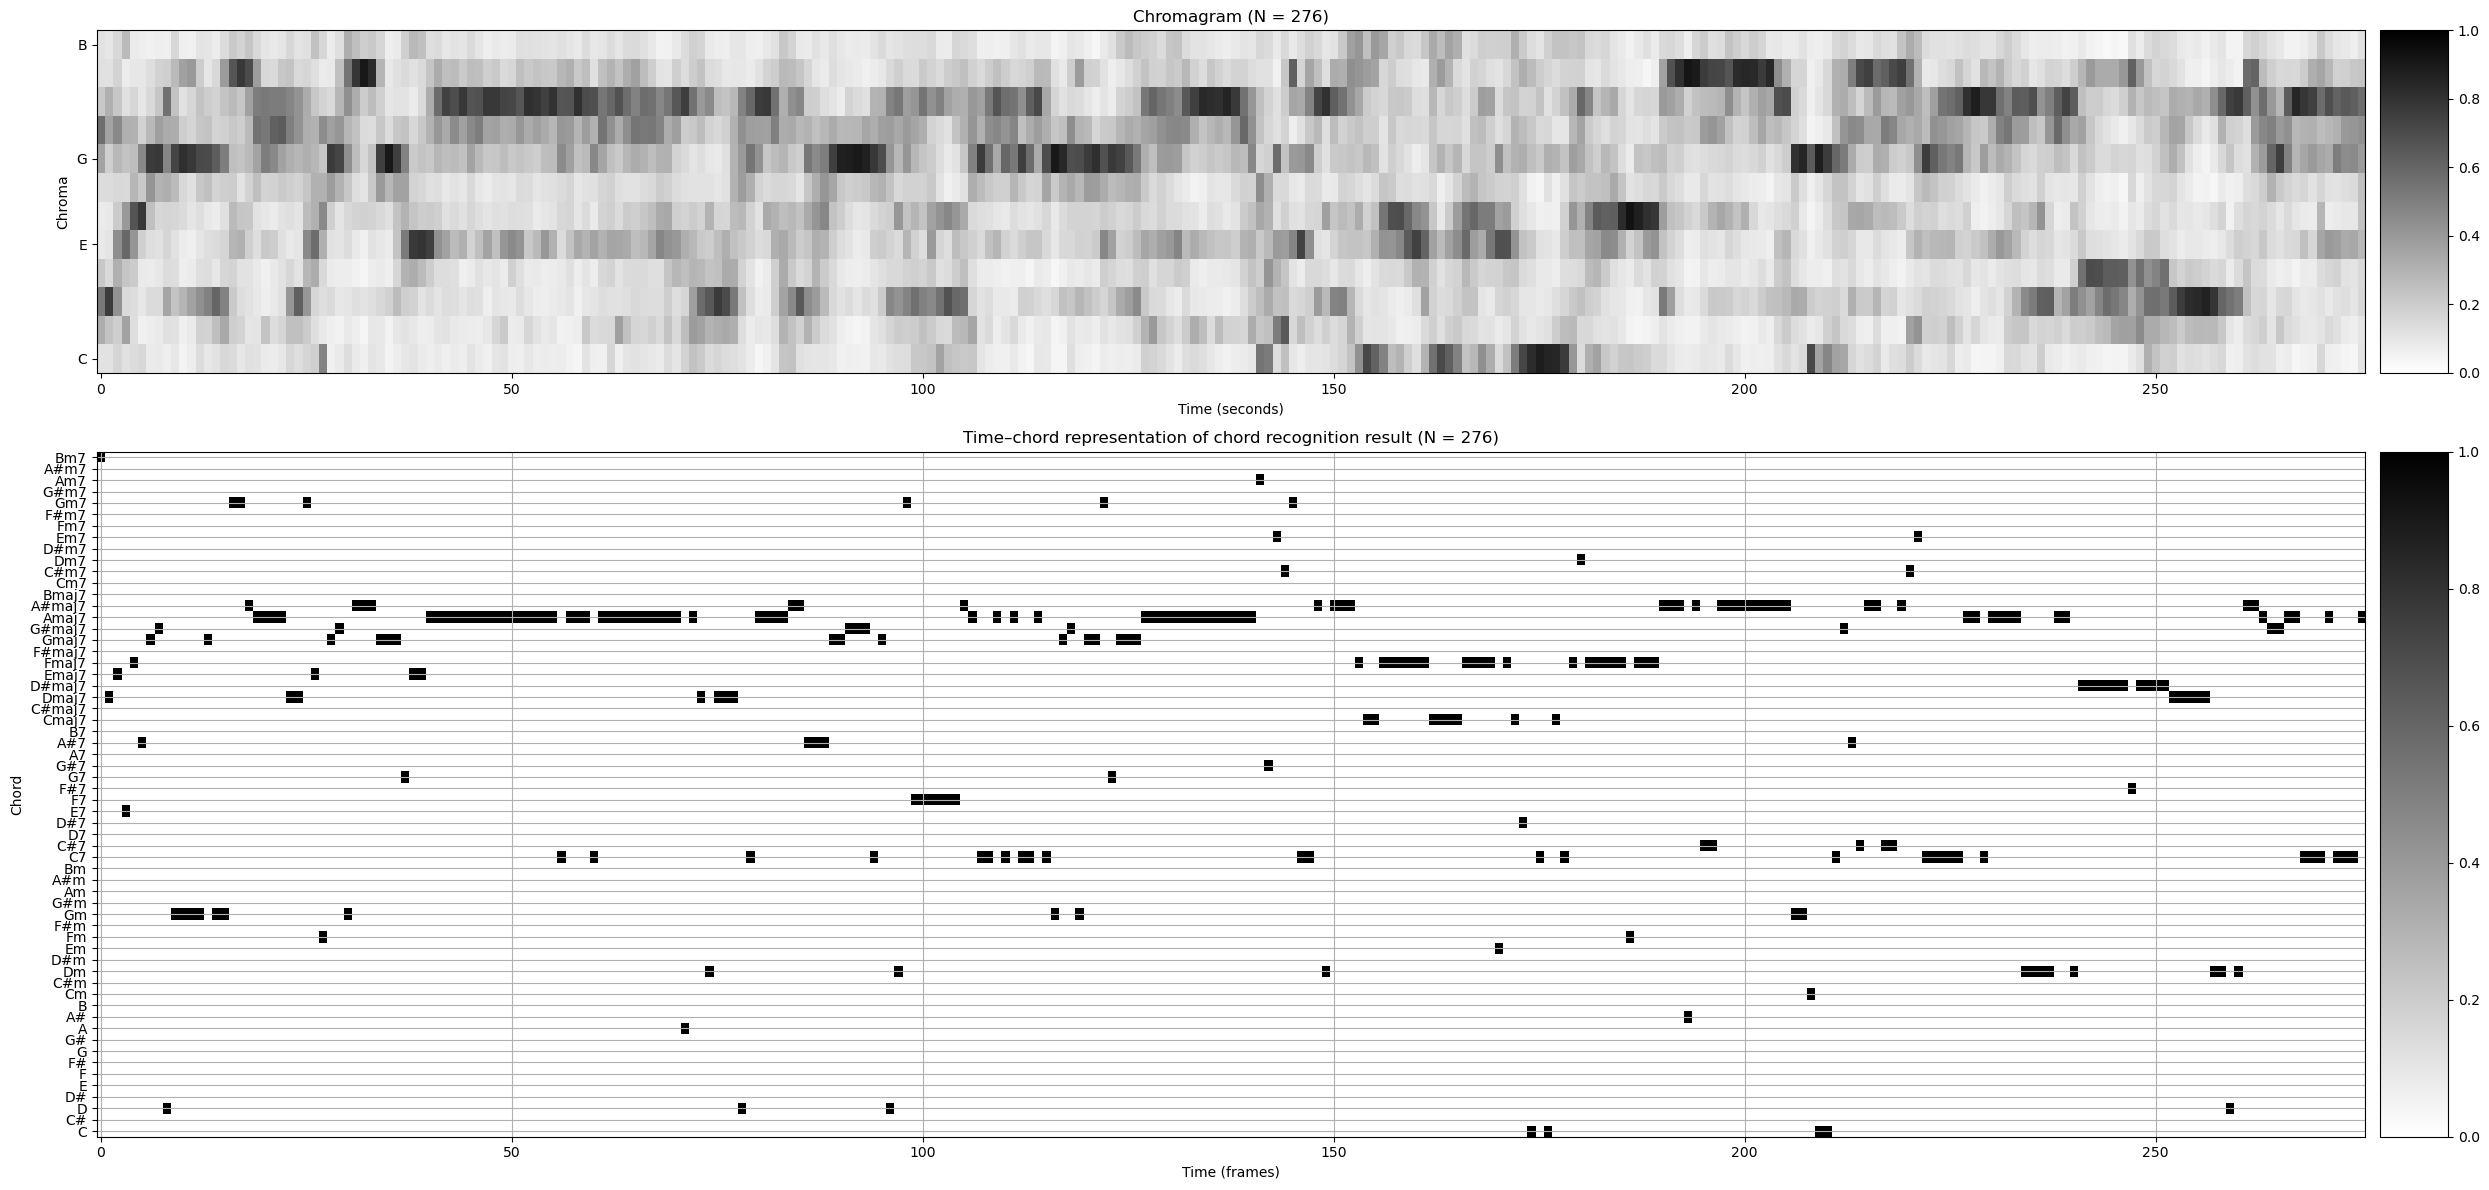

In [6]:
#Plot
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2]}, figsize=(25, 12))

title = 'Chromagram (N = %d)' % X.shape[1]
libfmp.b.plot_chromagram(X, Fs=1, ax=[ax[0, 0], ax[0, 1]],
                         chroma_yticks = [0, 4, 7, 11], clim=[0, 1], cmap='gray_r',
                         title=title, ylabel='Chroma', colorbar=True)

title = 'Time–chord representation of chord recognition result (N = %d)' % X.shape[1]
libfmp.b.plot_matrix(chord_max, ax=[ax[1, 0], ax[1, 1]], Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)')
ax[1, 0].set_yticks(np.arange(len(chord_labels)))
ax[1, 0].set_yticklabels(chord_labels)
ax[1, 0].grid()
plt.tight_layout()

In [7]:
def convert_chord_label(ann):
    """Replace for segment-based annotation in each chord label the string ':min' by 'm'
    and convert flat chords into sharp chords using enharmonic equivalence

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        ann (list): Segment-based annotation with chord labels

    Returns:
        ann_conv (list): Converted segment-based annotation with chord labels
    """
    ann_conv = copy.deepcopy(ann)

    for k in range(len(ann)):
        ann_conv[k][2] = ann_conv[k][2].replace(':min', 'm')
        ann_conv[k][2] = ann_conv[k][2].replace('Db', 'C#')
        ann_conv[k][2] = ann_conv[k][2].replace('Eb', 'D#')
        ann_conv[k][2] = ann_conv[k][2].replace('Gb', 'F#')
        ann_conv[k][2] = ann_conv[k][2].replace('Ab', 'G#')
        ann_conv[k][2] = ann_conv[k][2].replace('Bb', 'A#')
    return ann_conv

In [8]:
def convert_sequence_ann(seq, Fs=1):
    """Convert label sequence into segment-based annotation

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        seq (list): Label sequence
        Fs (scalar): Feature rate (Default value = 1)

    Returns:
        ann (list): Segment-based annotation for label sequence
    """
    ann = []
    for m in range(len(seq)):
        ann.append([(m-0.5) / Fs, (m+0.5) / Fs, seq[m]])
    return ann


In [9]:
def convert_chord_ann_matrix(fn_ann, chord_labels, Fs=1, N=None, last=False):
    """Convert segment-based chord annotation into various formats

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        fn_ann (str): Filename of segment-based chord annotation
        chord_labels (list): List of chord labels
        Fs (scalar): Feature rate (Default value = 1)
        N (int): Number of frames to be generated (by cutting or extending).
            Only enforced for ann_matrix, ann_frame, ann_seg_frame (Default value = None)
        last (bool): If 'True' uses for extension last chord label, otherwise uses nonchord label 'N'
            (Default value = False)

    Returns:
        ann_matrix (np.ndarray): Encoding of label sequence in form of a binary time-chord representation
        ann_frame (list): Label sequence (specified on the frame level)
        ann_seg_frame (list): Encoding of label sequence as segment-based annotation (given in indices)
        ann_seg_ind (list): Segment-based annotation with segments (given in indices)
        ann_seg_sec (list): Segment-based annotation with segments (given in seconds)
    """
    ann_seg_sec, _ = libfmp.c4.read_structure_annotation(fn_ann)
    ann_seg_sec = convert_chord_label(ann_seg_sec)
    ann_seg_ind, _ = libfmp.c4.read_structure_annotation(fn_ann, Fs=Fs, index=True)
    ann_seg_ind = convert_chord_label(ann_seg_ind)

    ann_frame = libfmp.c4.convert_ann_to_seq_label(ann_seg_ind)
    if N is None:
        N = len(ann_frame)
    if N < len(ann_frame):
        ann_frame = ann_frame[:N]
    if N > len(ann_frame):
        if last:
            pad_symbol = ann_frame[-1]
        else:
            pad_symbol = 'N'
        ann_frame = ann_frame + [pad_symbol] * (N-len(ann_frame))
    ann_seg_frame = convert_sequence_ann(ann_frame, Fs=1)

    num_chords = len(chord_labels)
    ann_matrix = np.zeros((num_chords, N))
    for n in range(N):
        label = ann_frame[n]
        # Generates a one-entry only for labels that are contained in "chord_labels"
        if label in chord_labels:
            label_index = chord_labels.index(label)
            ann_matrix[label_index, n] = 1
    return ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec

In [10]:
# Annotations
fn_ann = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/if_0172_chords_converted.csv')
# chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=False)
chord_labels = get_chord_labels_extended(nonchord=False)
N_X = X.shape[1]
ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = convert_chord_ann_matrix(fn_ann, chord_labels, 
                                                                           Fs=Fs_X, N=N_X, last=True)

# color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
#              'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1], 'N': [1, 1, 1, 1]}

import matplotlib.cm as cm
# 2) Extract all unique chord labels
unique_chords = sorted(set([label for (start, end, label) in ann_seg_sec]))

# 3) Choose a colormap and generate a color for each label
#    e.g., 'tab20' can provide up to 20 distinct colors. 
#    If you have more than 20 chords, pick a different colormap
#    or set a larger "N" parameter (some colormaps support this).
cmap = cm.get_cmap('tab20', len(unique_chords))

# 4) Build a dictionary {chord_label: (RGBA color)}
color_ann = {}
for idx, chord_label in enumerate(unique_chords):
    # 'cmap(idx)' returns an RGBA tuple in the range [0,1]
    color_ann[chord_label] = cmap(idx)

/tmp/ipykernel_122400/2066460392.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_chords))


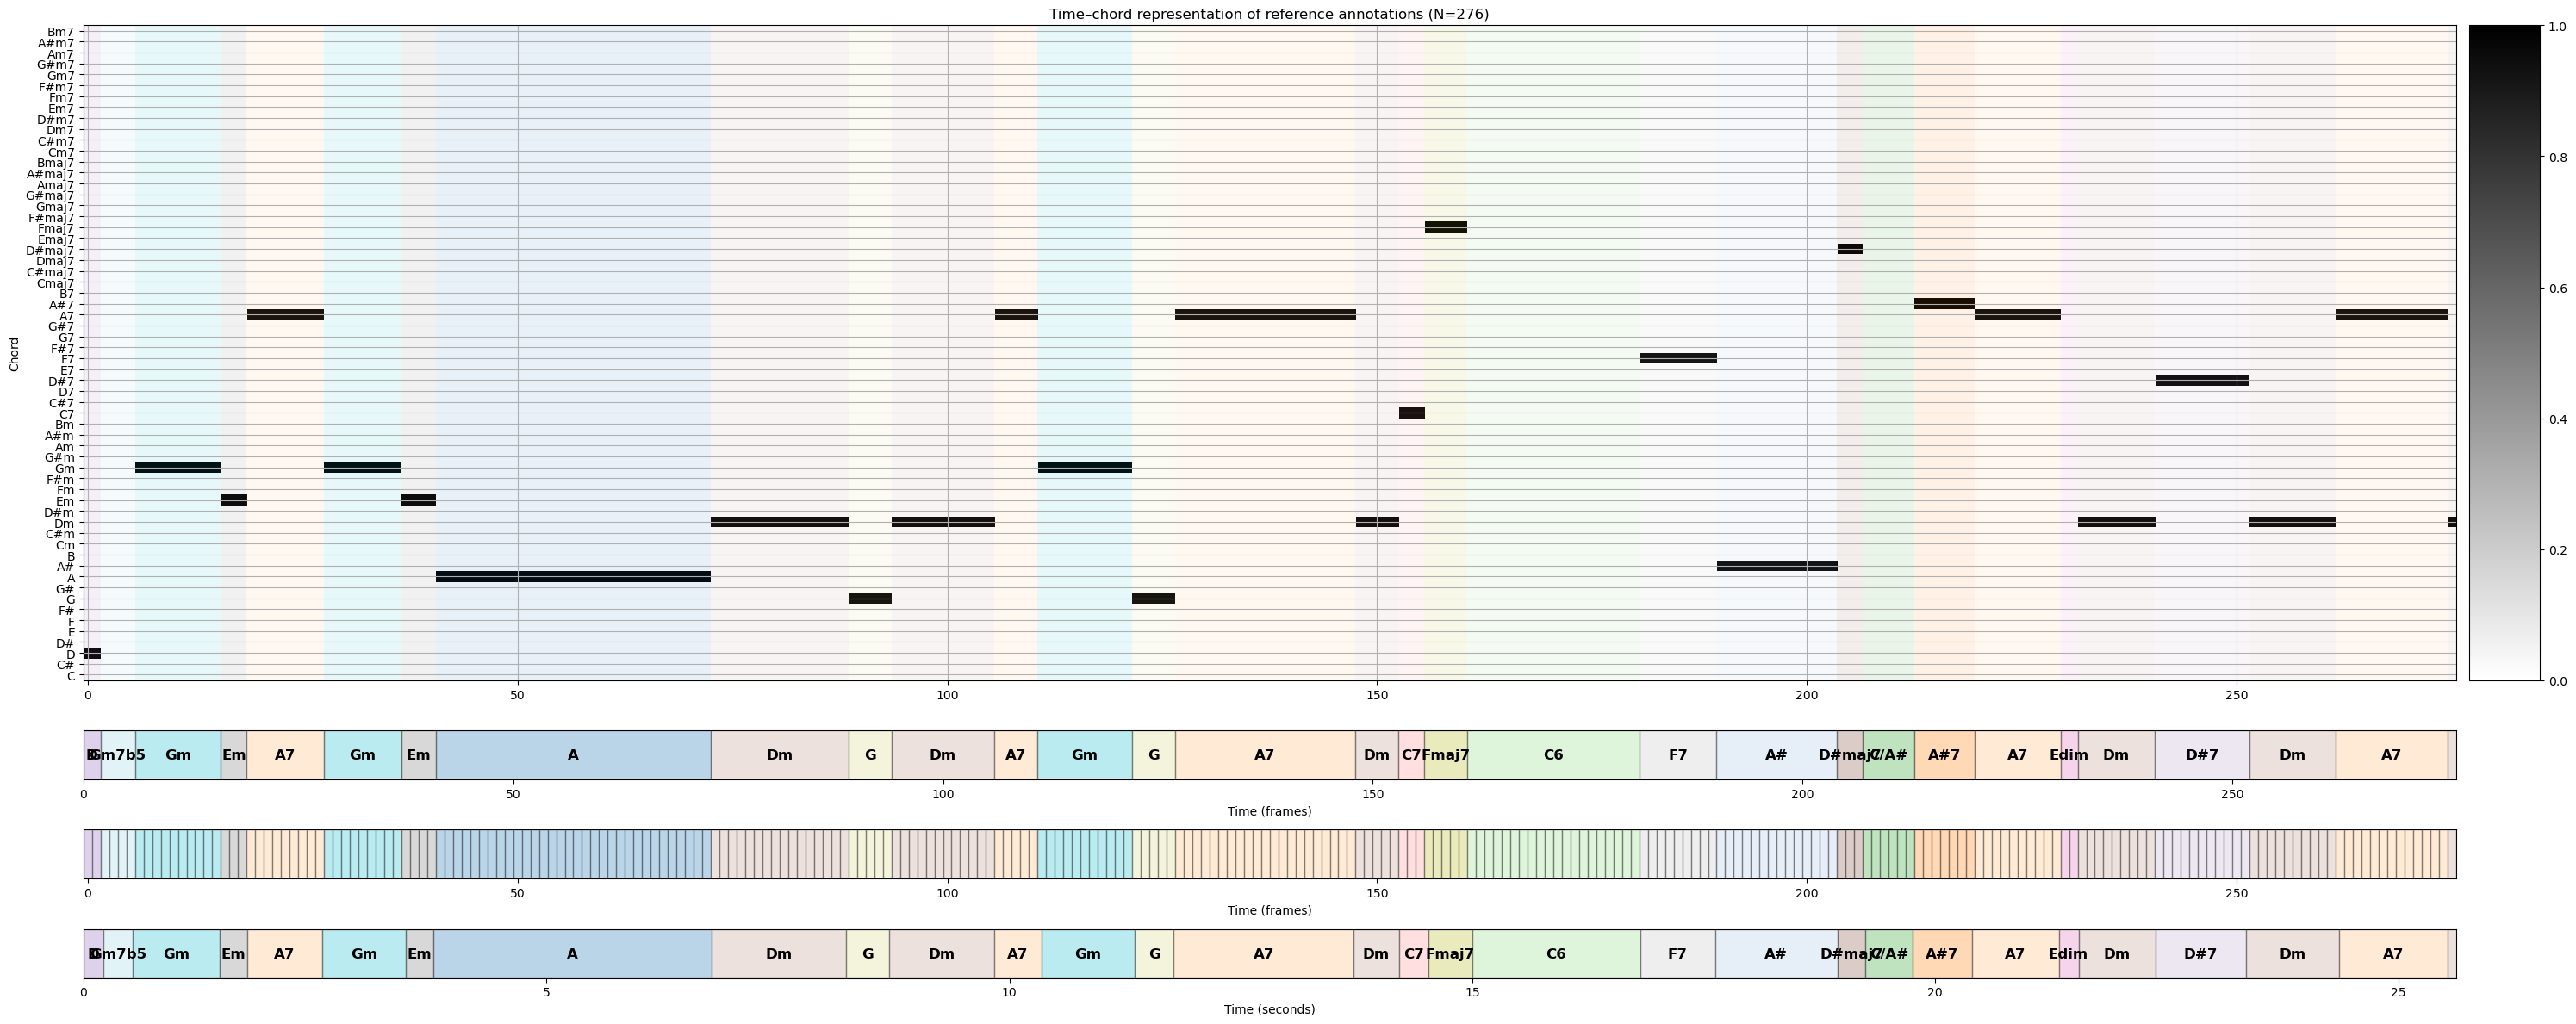

In [12]:
# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [4, 0.3, 0.3, 0.3]}, 
                       figsize=(30, 12))

libfmp.b.plot_matrix(ann_matrix, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                     title='Time–chord representation of reference annotations (N=%d)' % ann_matrix.shape[1],
                     ylabel='Chord', xlabel='')
ax[0, 0].set_yticks(np.arange( len(chord_labels) ))
ax[0, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann_seg_frame, ax=ax[0, 0], 
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0, 0].grid()
libfmp.b.plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
libfmp.b.plot_segments(ann_seg_frame, ax=ax[2, 0], time_label='Time (frames)', 
                       colors=color_ann,  alpha=0.3, print_labels=False)
ax[2, 1].axis('off')
libfmp.b.plot_segments(ann_seg_sec, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

In [13]:
def compute_eval_measures(I_ref, I_est):
    """Compute evaluation measures including precision, recall, and F-measure

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        I_ref (np.ndarray): Reference set of items
        I_est (np.ndarray): Set of estimated items

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
    """
    assert I_ref.shape == I_est.shape, "Dimension of input matrices must agree"
    TP = np.sum(np.logical_and(I_ref, I_est))
    FP = np.sum(I_est > 0, axis=None) - TP
    FN = np.sum(I_ref > 0, axis=None) - TP
    P = 0
    R = 0
    F = 0
    if TP > 0:
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F = 2 * P * R / (P + R)
    return P, R, F, TP, FP, FN

In [14]:
def plot_matrix_chord_eval(I_ref, I_est, Fs=1, xlabel='Time (seconds)', ylabel='Chord',
                           title='', chord_labels=None, ax=None, grid=True, figsize=(9, 3.5)):
    """Plots TP-, FP-, and FN-items in a color-coded form in time–chord grid

    Notebook: C5/C5S2_ChordRec_Eval.ipynb

    Args:
        I_ref: Reference set of items
        I_est: Set of estimated items
        Fs: Feature rate (Default value = 1)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Chord')
        title: Title of figure (Default value = '')
        chord_labels: List of chord labels used for vertical axis (Default value = None)
        ax: Array of axes (Default value = None)
        grid: If "True" the plot grid (Default value = True)
        figsize: Size of figure (if axes are not specified) (Default value = (9, 3.5))

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax = [ax]
    I_TP = np.sum(np.logical_and(I_ref, I_est))
    I_FP = I_est - I_TP
    I_FN = I_ref - I_TP
    I_vis = 3 * I_TP + 2 * I_FN + 1 * I_FP

    eval_cmap = colors.ListedColormap([[1, 1, 1], [1, 0.3, 0.3], [1, 0.7, 0.7], [0, 0, 0]])
    eval_bounds = np.array([0, 1, 2, 3, 4])-0.5
    eval_norm = colors.BoundaryNorm(eval_bounds, 4)
    eval_ticks = [0, 1, 2, 3]

    T_coef = np.arange(I_vis.shape[1]) / Fs
    F_coef = np.arange(I_vis.shape[0])
    x_ext1 = (T_coef[1] - T_coef[0]) / 2
    x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
    y_ext1 = (F_coef[1] - F_coef[0]) / 2
    y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
    extent = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]

    im = ax[0].imshow(I_vis,  origin='lower', aspect='auto', cmap=eval_cmap, norm=eval_norm, extent=extent,
                      interpolation='nearest')
    if len(ax) == 2:
        cbar = plt.colorbar(im, cax=ax[1], cmap=eval_cmap, norm=eval_norm, boundaries=eval_bounds, ticks=eval_ticks)
    elif len(ax) == 1:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, cmap=eval_cmap, norm=eval_norm, boundaries=eval_bounds, ticks=eval_ticks)
    cbar.ax.set_yticklabels(['TN', 'FP', 'FN', 'TP'])
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if chord_labels is not None:
        ax[0].set_yticks(np.arange(len(chord_labels)))
        ax[0].set_yticklabels(chord_labels)
    if grid is True:
        ax[0].grid()
    return fig, ax, im

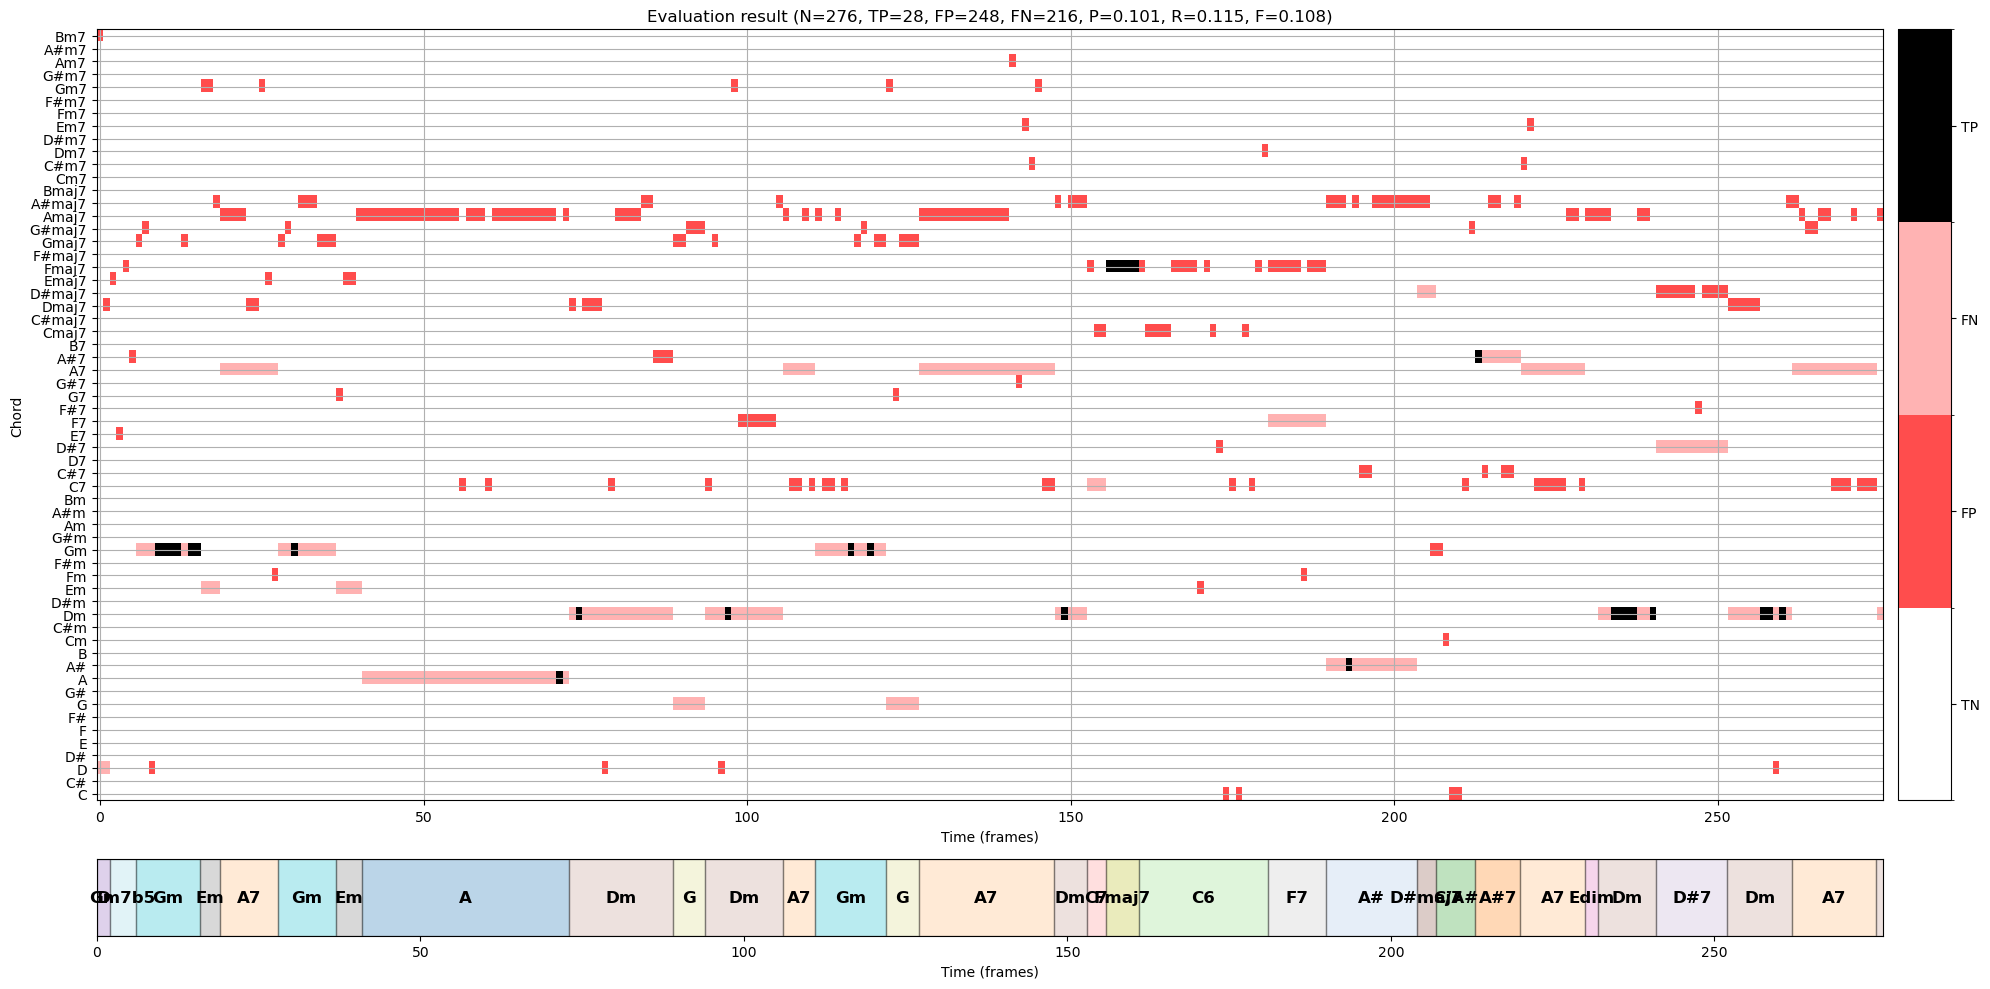

In [16]:
P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 0.2]}, figsize=(20, 10))

title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                       title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

libfmp.b.plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plt.tight_layout()
plt.show()

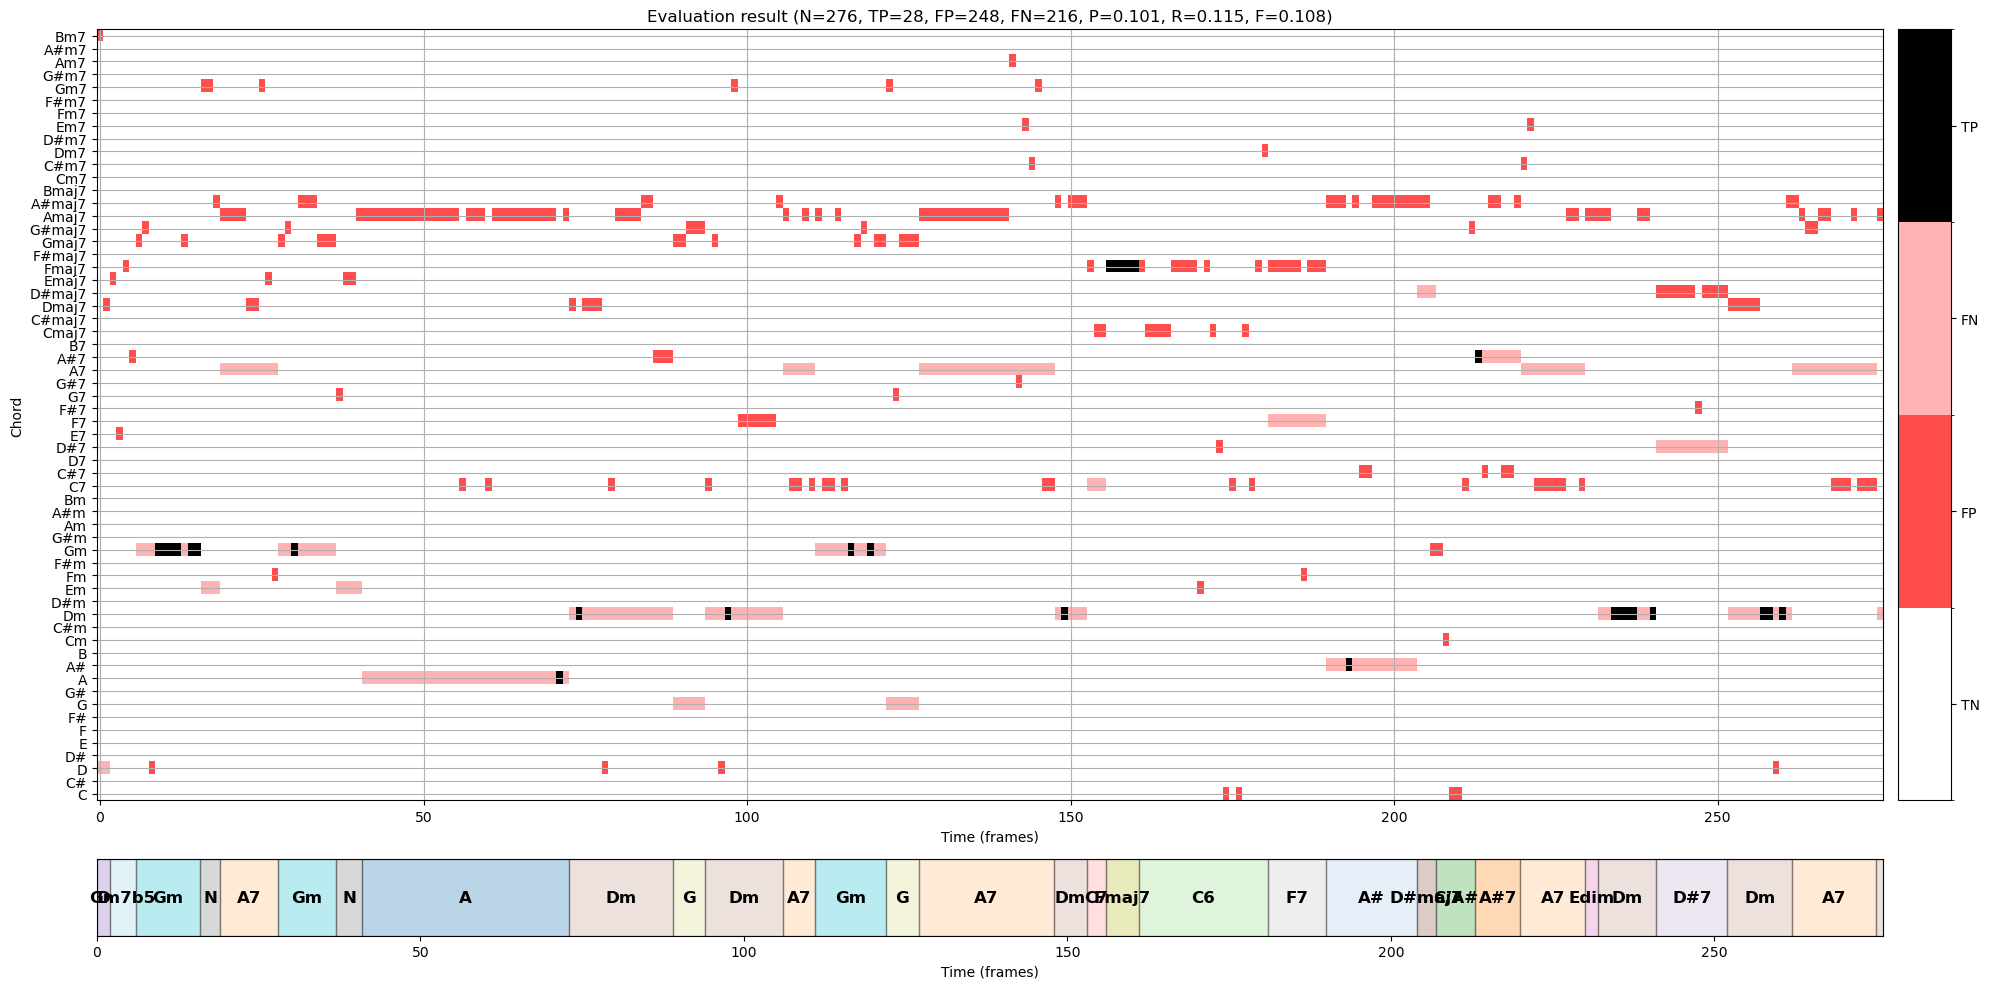

In [18]:
ann_matrix[5, :] = 0
ann_seg_ind[3][2] = 'N'
ann_seg_ind[6][2] = 'N'

P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)


fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 0.2]}, figsize=(20, 10))

title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                       title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

libfmp.b.plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1,1].axis('off')
plt.tight_layout()
plt.show()

In [19]:
def experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma, H_chroma, gamma=1,
                                         version='STFT'):
    # Compute chromagram
    X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N_chroma, H=H_chroma, 
                                                                       gamma=gamma, version=version)
    N_X = X.shape[1]

    # Chord recogntion
    chord_sim, chord_max = libfmp.c5.chord_recognition_template(X, norm_sim='max')
    chord_labels = libfmp.c5.get_chord_labels(nonchord=False)

    # Annotations
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=False)
    ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = \
        convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=True)

    P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

    fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                              'height_ratios': [1, 2, 0.2]}, figsize=(9, 6))

    title = title='Chromagram with window size = %.3f (seconds)' % (N_chroma / Fs)
    libfmp.b.plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=1, clim=[0, 1], xlabel='', title=title)
    libfmp.b.plot_segments_overlay(ann_seg_frame, ax=ax[0, 0], 
                                   print_labels=False, colors=color_ann, alpha=0.1)

    title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, F=%.3f)' % (N_X, TP, FP, FN, F)
    plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[1, 0], ax[1, 1]], Fs=1, 
                         title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

    libfmp.b.plot_segments(ann_seg_ind, ax=ax[2, 0], time_label='Time (frames)', time_max=N_X,
                           colors=color_ann,  alpha=0.3)
    ax[2, 1].axis('off')
    plt.tight_layout()
    plt.show()

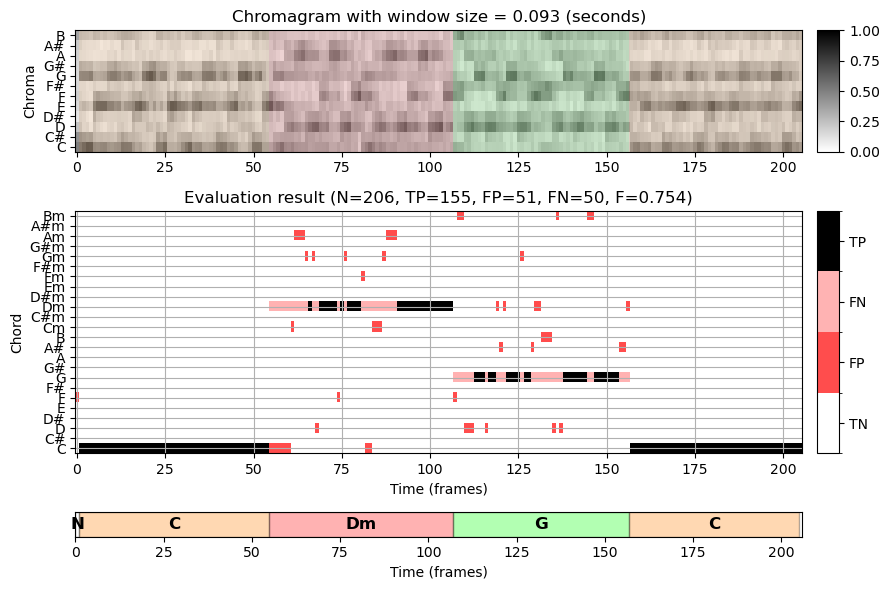

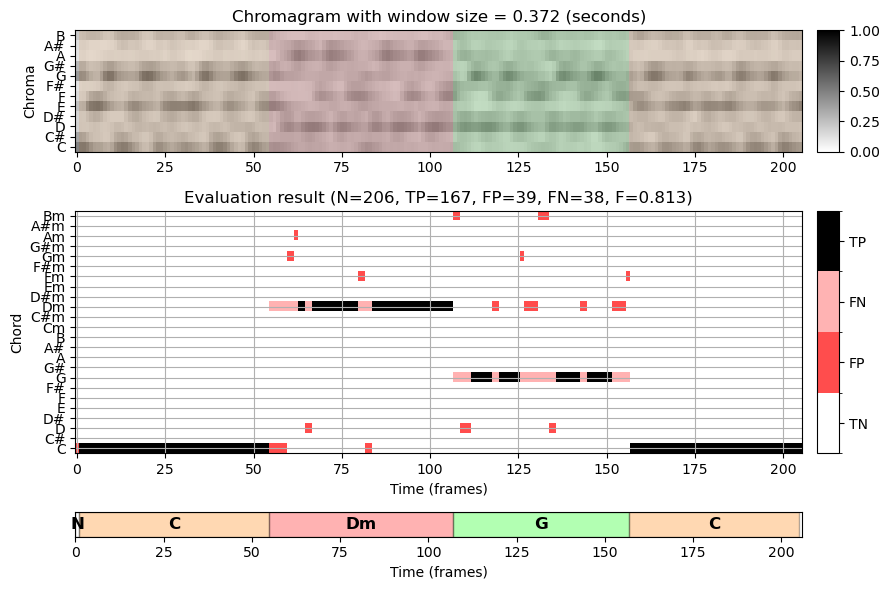

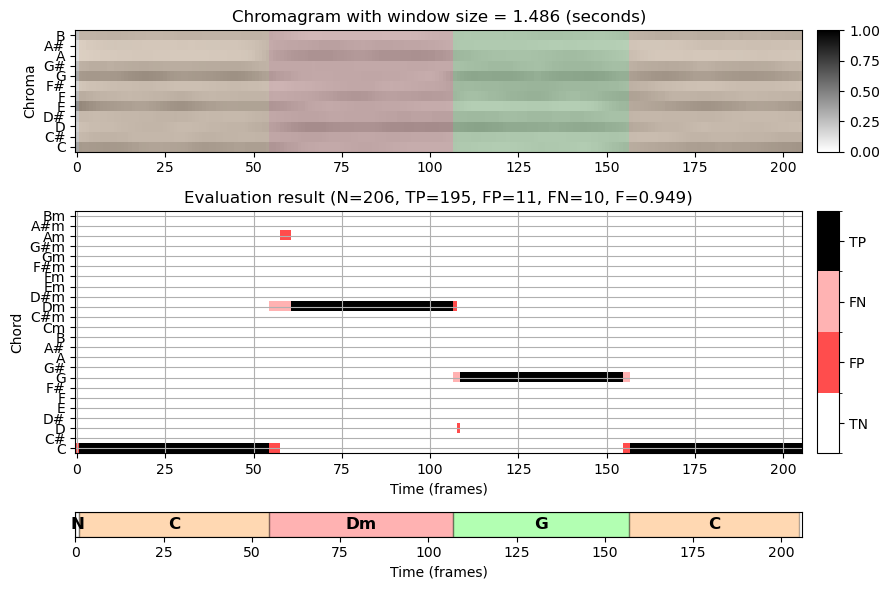

In [15]:
fn_wav = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav')
fn_ann = os.path.join('/home/cepatinog/ethnomusic/amplab-musicology-andina/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer_ChordAnnotations.csv')
color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Dm': [1, 0, 0, 1], 'N': [1, 1, 1, 1]}

experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048, H_chroma=1024)
experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048*4, H_chroma=1024)
experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048*16, H_chroma=1024)